# WiDS Tel Aviv
## Tutorial – Dealing with the Lack of Audio Data
In recent years, speech data is receiving spotlight for various applications in deep learning, from Automatic Speech Recognition (ASR) system to source separation. And yet, there are not many augmentation techniques explored for speech data compared to those of image data. Thus, in this track, we will explore various methods to augment speech data. This hands-on tutorial will work along the task of building a simple speech classifier with the Speech Commands Zero to Nine (SC09) dataset available by TensorFlow and go over traditional augmentation techniques, transfer learning, GAN augmentation, and style transfer to increase the classification accuracy. Participants are required to download the libraries and pre-trained models, which will be available in late-January.

## Load training data

In [1]:
# load sample audio from sc09 dataset
import os
from glob import glob
import IPython.display as ipd

label_paths = glob('../../data/sc09/*')

for label_path in label_paths:
    sample_wav = glob(os.path.join(label_path, '*.wav'))[0]
    print("Class:", sample_wav.split('/')[-2])
    ipd.display(ipd.Audio(sample_wav))

Class: eight


Class: nine


Class: three


Class: one


Class: zero


Class: seven


Class: two


Class: six


Class: five


Class: four


## Wav2img

/Users/acheketa/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


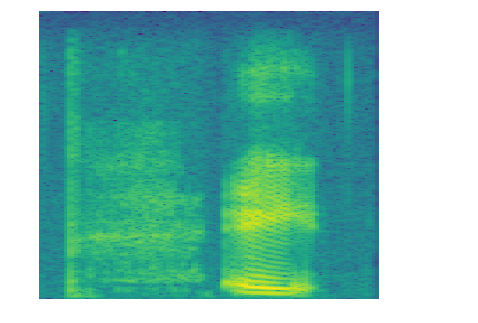

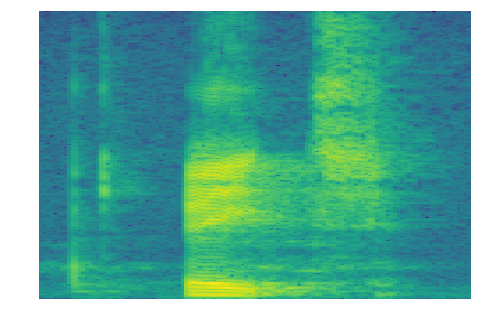

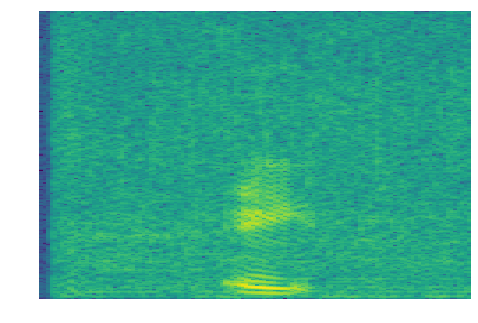

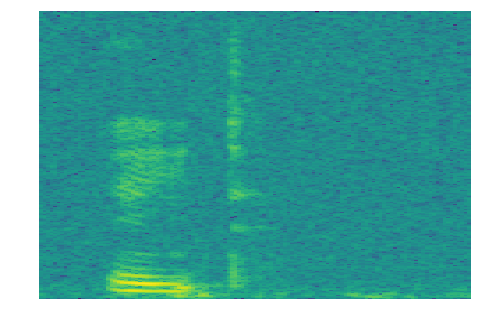

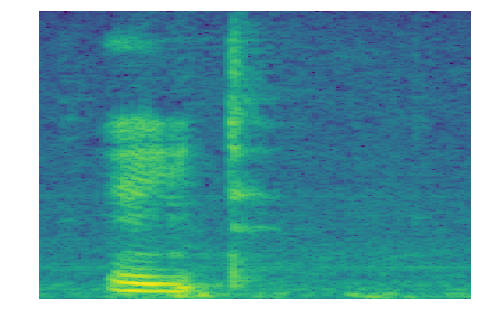

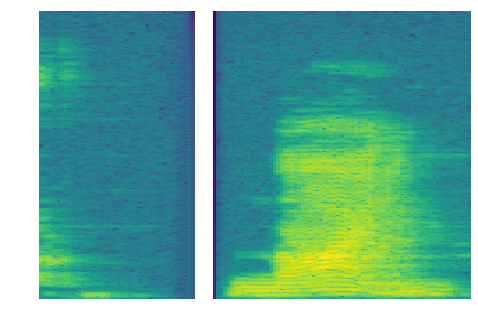

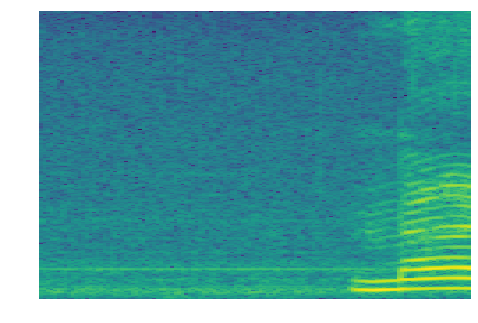

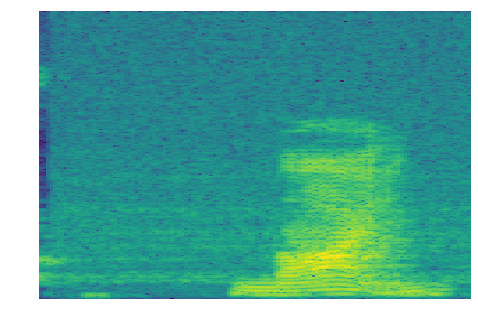

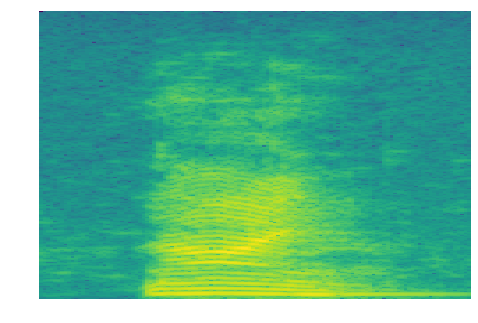

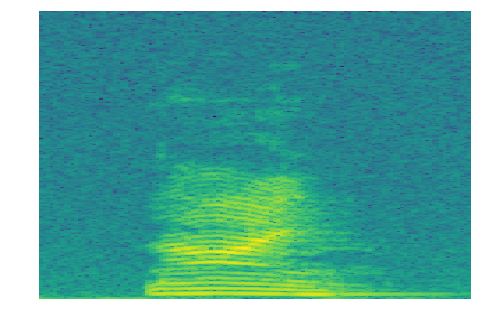

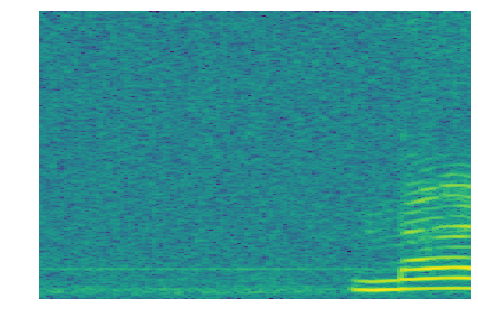

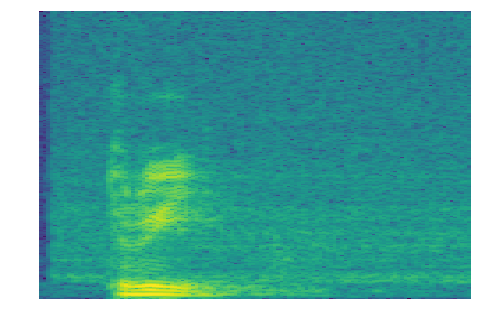

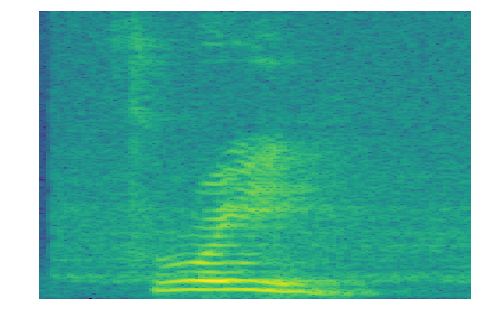

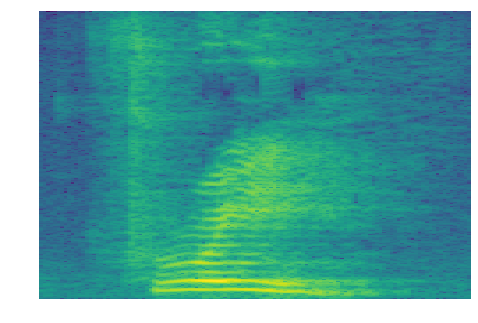

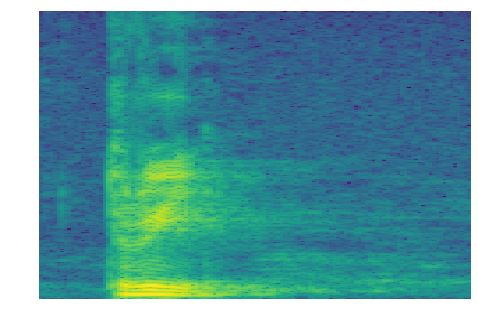

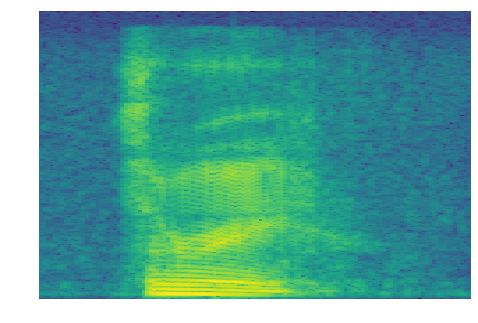

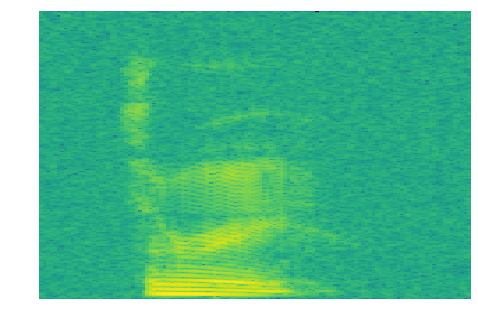

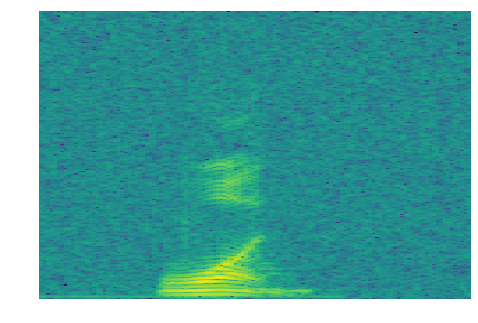

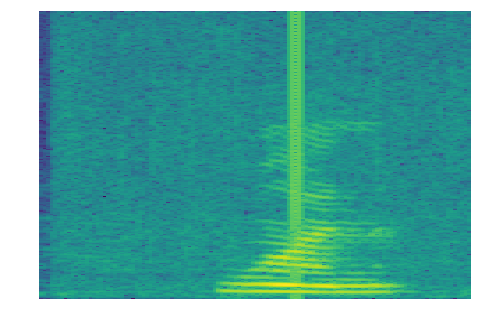

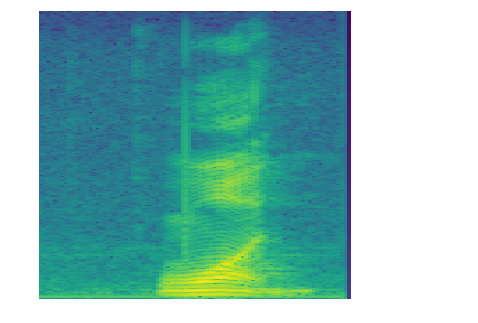

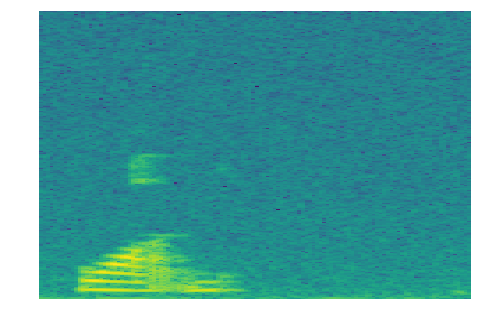

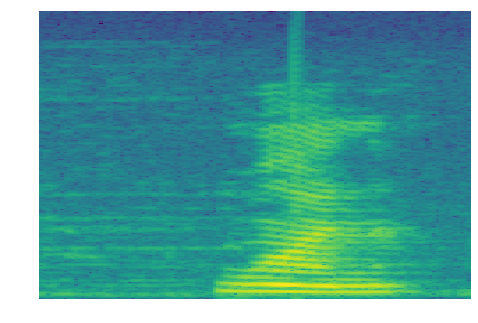

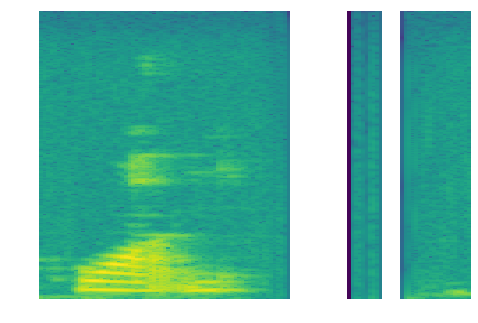

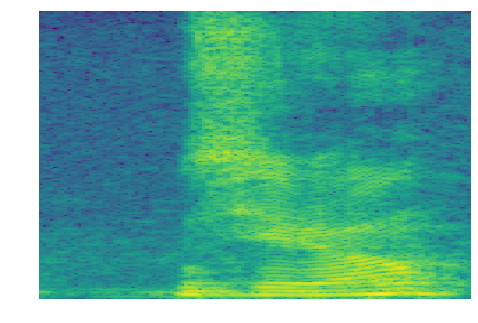

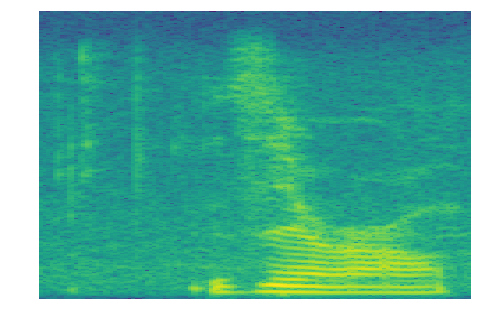

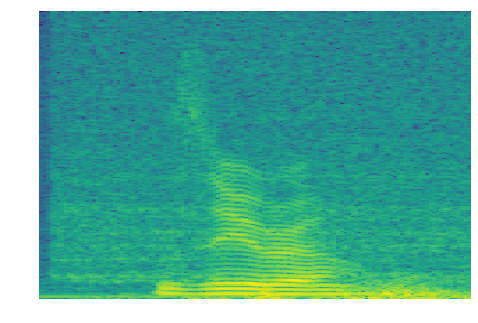

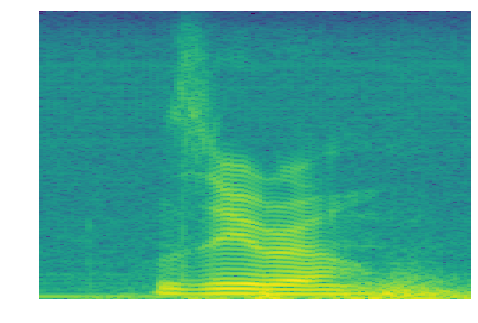

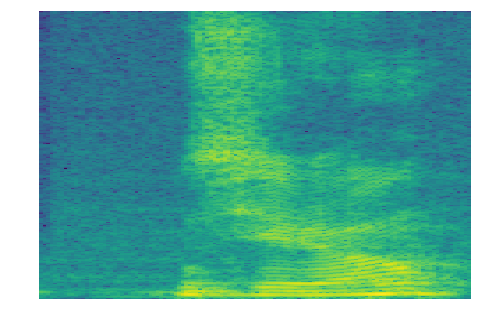

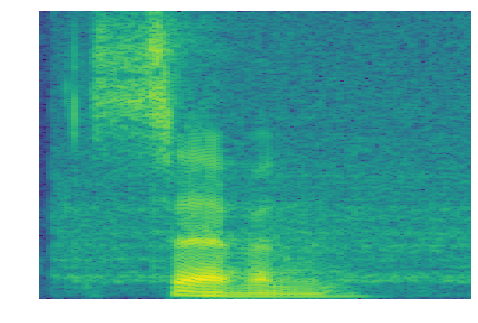

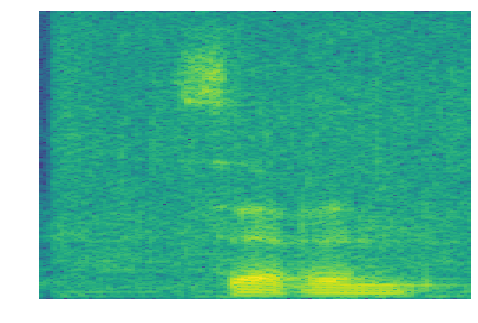

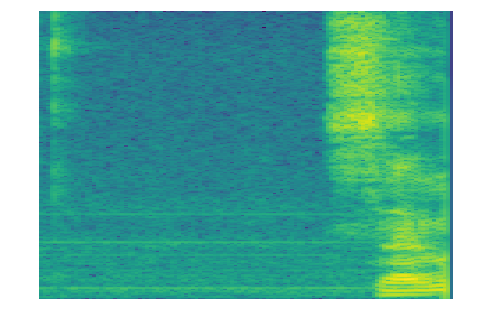

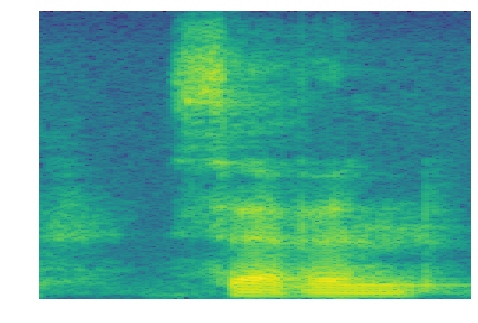

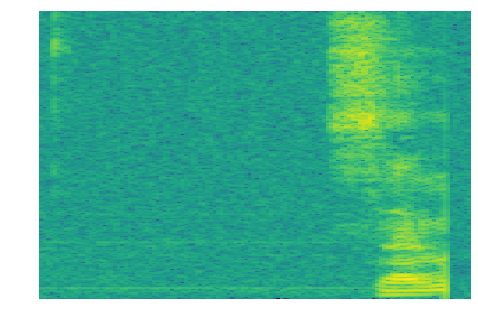

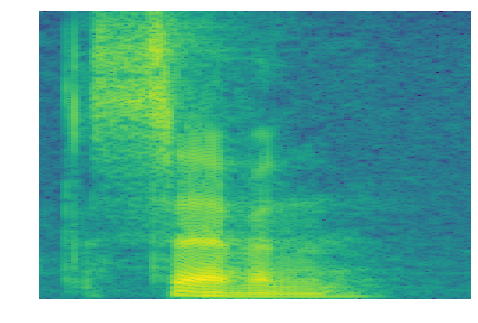

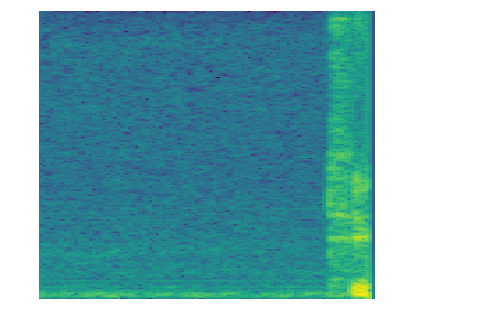

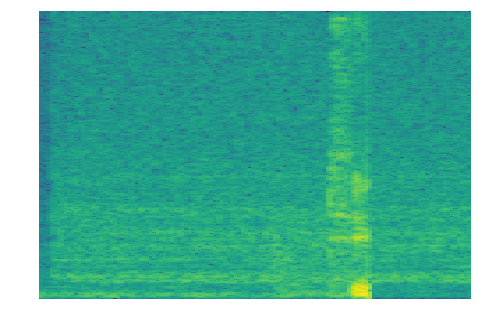

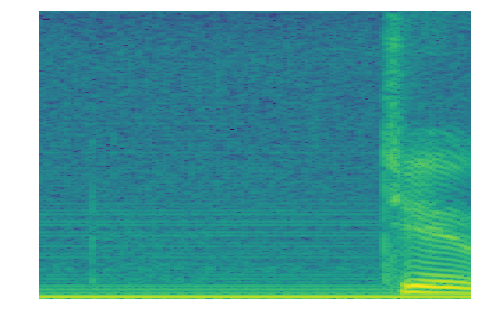

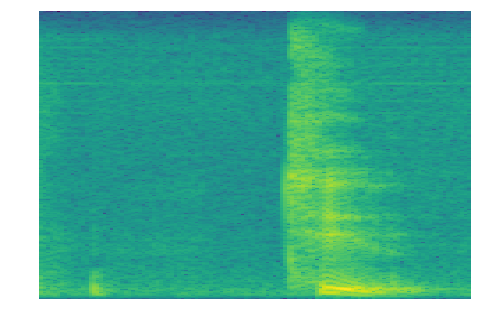

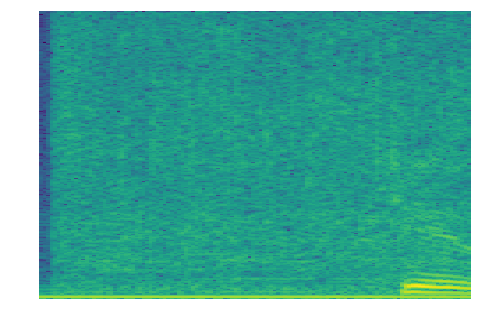

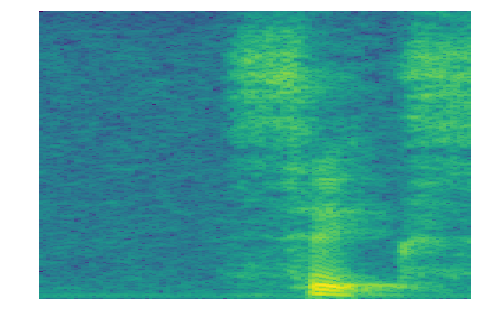

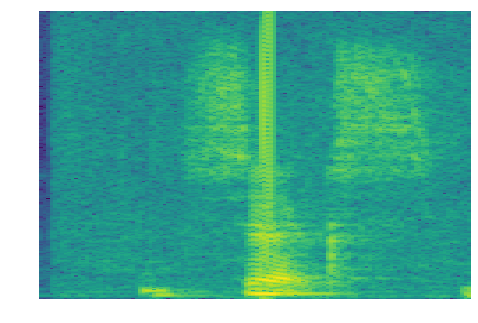

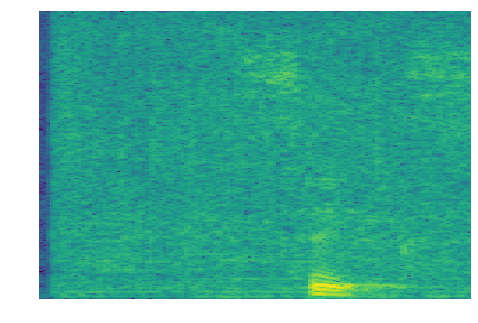

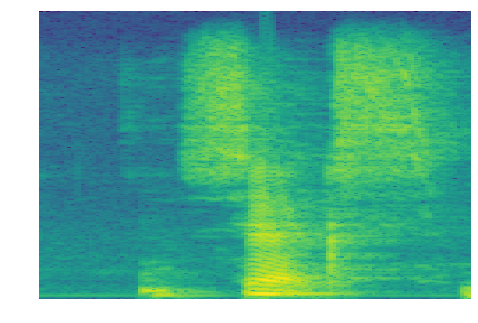

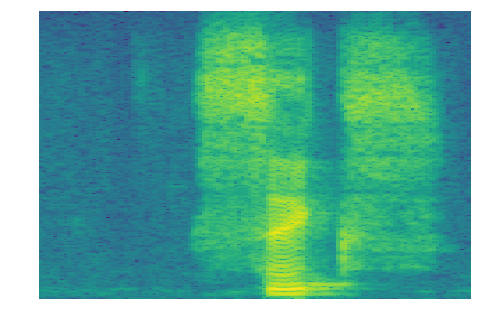

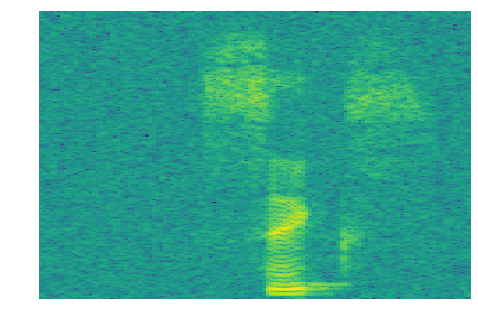

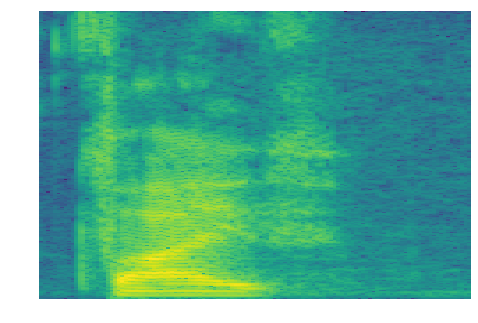

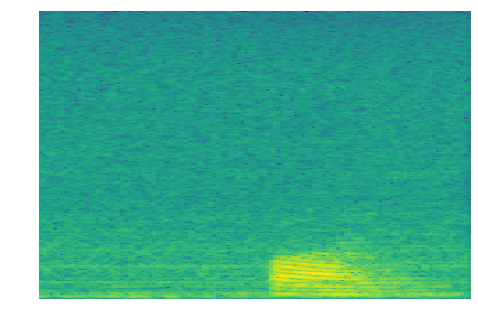

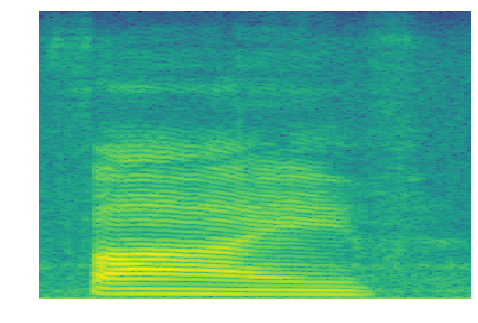

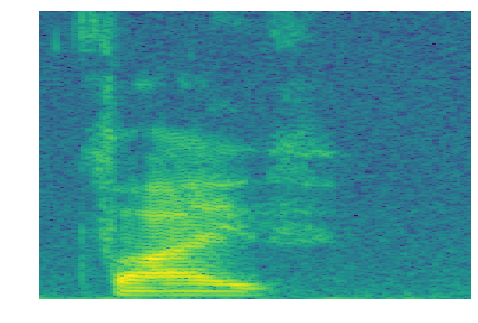

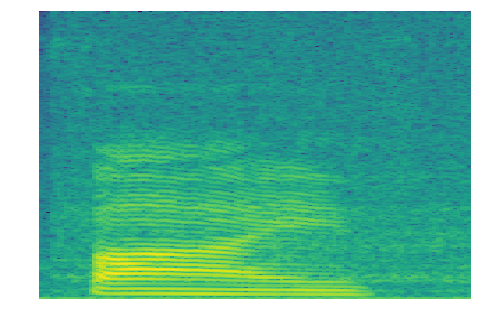

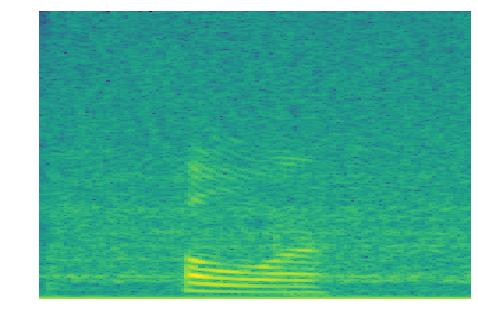

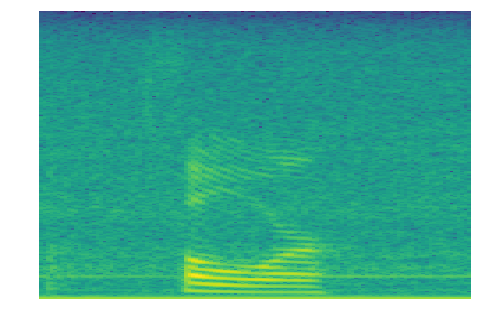

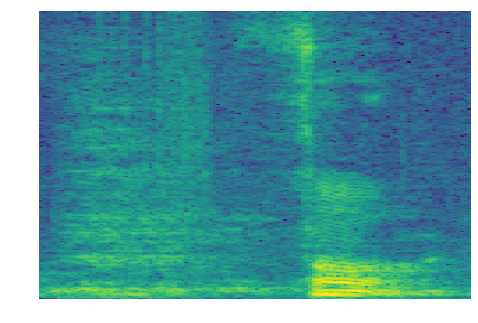

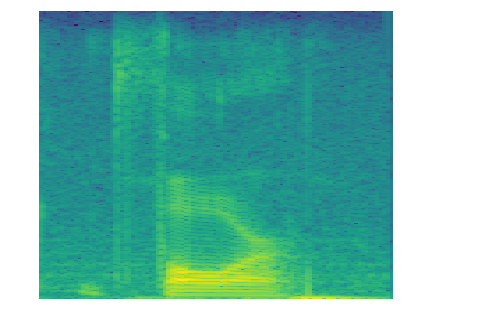

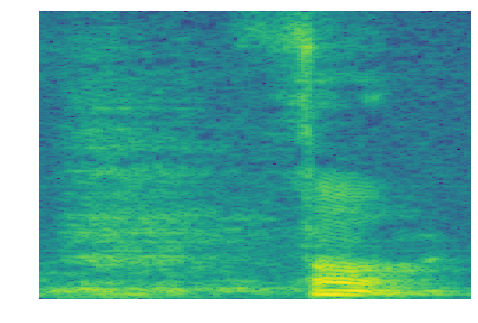

In [2]:
# Convert sample wav files into spectrogram images
# load sample audio from sc09 dataset
%matplotlib inline
import os
from glob import glob
import IPython.display as ipd
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

label_paths = glob('../../data/sc09/*/*.wav')
LEN = 16000

for sample_wav in label_paths:
    ipd.display(ipd.Audio(sample_wav))
    
    # read .wav
    rate, data = wavfile.read(sample_wav)
    
    if len(data) > LEN:
        data = data[:LEN]
    else:
        data = np.pad(data, (0, max(0, LEN - len(data))), "constant")
    
    # spectrogram img
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    pxx, freqs, bins, im = ax.specgram(x=data, Fs=rate, noverlap=384, NFFT=512)
    ax.axis('off')
    fig.savefig(sample_wav[:-4] + '.jpg', dpi=300, frameon='false')
    plt.show()
    plt.close()

## Baseline model

In [1]:
# Show Tensorboard for training and evaluation
# Describe the code in presentation
# Let people inference with sample data

# Some basic imports and and setups
import cv2, random
from glob import glob
import matplotlib.pyplot as plt
import IPython.display as ipd

# Parameters
ckpt_path = '../training/baseline/checkpoint/model_epoch10.ckpt'

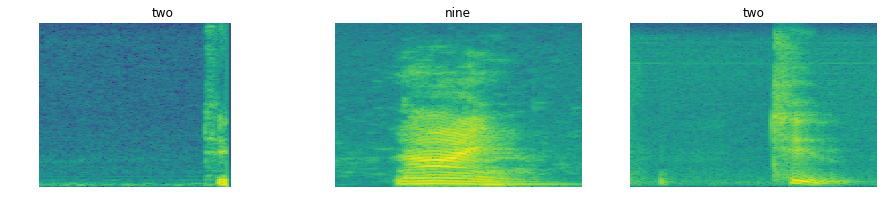

In [2]:
# Get list of test images
image_dir = glob('../../data/sc09/*/*.jpg')
image_dir = random.sample(image_dir, 3)

# Load test images
imgs = []
gt = []
for f in image_dir:
    imgs.append(cv2.imread(f))
    gt.append(f.split('/')[-2])
    
# Plot images
fig = plt.figure(figsize=(15,6))
for i, img in enumerate(imgs):
    fig.add_subplot(1,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(gt[i])
    plt.axis('off')

First we will create placeholder for the dropout rate and the inputs and create an AlexNet object. Then we will link the activations from the last layer to the variable score and define an op to calculate the softmax values.

In [3]:
import tensorflow as tf
import numpy as np
from model import AlexNetModel

# Placeholders
x = tf.placeholder(tf.float32, [1, 227, 227, 3])
keep_prob = tf.placeholder(tf.float32)
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

# Model
model = AlexNetModel(num_classes=10, dropout_keep_prob=keep_prob)
score = model.inference(x)
saver = tf.train.Saver()

INFO:tensorflow:Restoring parameters from ../training/finetuned/checkpoint/model_epoch10.ckpt
Class: two


Class: nine


Class: two


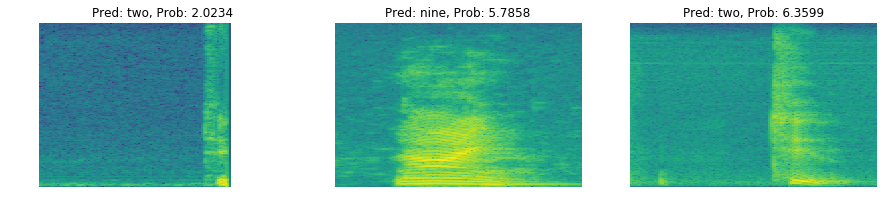

In [4]:
with tf.Session() as sess:
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())

    # Load pre-trained weights
    saver.restore(sess, ckpt_path)

    # Create figure handle
    fig2 = plt.figure(figsize=(15,6))
    
    # Loop over all images
    for i, image in enumerate(imgs):
        
        # Convert image to float32 and resize it
        img = cv2.resize(image.astype(np.float32), (227,227))
        img = img.reshape((1,227,227,3))
        
        # Run the session and calculate the class probability
        probs = sess.run(score, feed_dict={x: img, keep_prob: 1})
        
        # Get the class name of the class with the highest probability
        class_name = labels[np.argmax(probs)]
        
        # Load audio
        print("Class: " + gt[i])
        ipd.display(ipd.Audio(image_dir[i][:-4] + '.wav'))
        
        # Plot image with class name and prob in the title
        fig2.add_subplot(1,3,i+1)
        plt.title("Pred: " + class_name + ", Prob: %.4f" %probs[0,np.argmax(probs)])
        plt.axis('off')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Add noise to train data

In [ ]:
import IPython.display as ipd
from scipy.io import wavfile
from glob import glob
import random

LEN = 16000
NOISE_FREQUENCY = 0.8

noise_path = glob('../../data/_background_noise_/*.wav')
noises = []

for noise_file in noise_path:
    print(noise_file.split('/')[-1][:-4])
    noise = wavfile.read(noise_file)[1][:LEN]
    noises.append(noise)
    ipd.display(ipd.Audio(noise_file))

In [ ]:
# Load train audio
path = '../../data/sc09/*/*.wav'
wav_path = glob(path)
random.shuffle(wav_path)

# add background noise
for idx, wave in enumerate(wav_path):
    data = wavfile.read(wave)[1]
    if idx <= len(wav_path) * NOISE_FREQUENCY:
        if len(data) < LEN:
            data = np.pad(data, (0, max(0, LEN - len(data))), "constant")
        else:
            data = data[:LEN]
        index = random.randint(0, 4)
        noise_data = noises[index]
        wavfile.write(wave[:-4] + '_noise.wav', LEN, data + noise_data)

## Transfer Learning

In [ ]:
# What is transfer learning
# Show SC training by adjusting num_classes
# Inference with SC09 --> bad eval result
# Now fine tuning model layer is somewhat different

# Load checkpoint and turn it into a numpy file
import tensorflow as tf
import numpy as np
import sys
from model import AlexNetModel


# Edit just these
FILE_PATH = '../training/speech_command/checkpoint/model_epoch10.ckpt'
NUM_CLASSES = 20
OUTPUT_FILE = 'sc_epoch10.npy'


if __name__ == '__main__':
    x = tf.placeholder(tf.float32, [128, 227, 227, 3])
    model = AlexNetModel(num_classes=NUM_CLASSES)
    model.inference(x)

    saver = tf.train.Saver()
    layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc8']
    data = {
        'conv1': [],
        'conv2': [],
        'conv3': [],
        'conv4': [],
        'conv5': [],
        'fc8': []
    }

    with tf.Session() as sess:
        saver.restore(sess, FILE_PATH)

        for op_name in layers:
          with tf.variable_scope(op_name, reuse = True):
            biases_variable = tf.get_variable('biases')
            weights_variable = tf.get_variable('weights')
            data[op_name].append(sess.run(biases_variable))
            data[op_name].append(sess.run(weights_variable))

        np.save(OUTPUT_FILE, data)

## GAN Synthesis

In [ ]:
# What is DCGAN
# Why generate
# Results unstable
# Not going to be done here (Tensorboard)
# So the solution? CycleGAN loss (more stable) --> CycleGAN generation needs "features" --> here "gender"
# Explain CycleGAN in the presentation
# Gender dataset load it, explain it, listen to it, compare & contrast two classes
# Tensorboard --> inference (generation) --> use as training data --> baseline classifier (Tensorboard) --> inference it with normal SC09 dataset
